In [91]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset = tf.keras.utils.image_dataset_from_directory(
    'data',
    shuffle = True,
    batch_size = 30,
)

Found 4188 files belonging to 4 classes.


In [3]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [4]:
len(dataset)

140

In [5]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(30, 256, 256, 3)
[3 3 3 1 0 1 3 0 1 1 0 1 3 3 2 3 3 0 1 3 3 2 0 3 0 1 0 0 0 1]


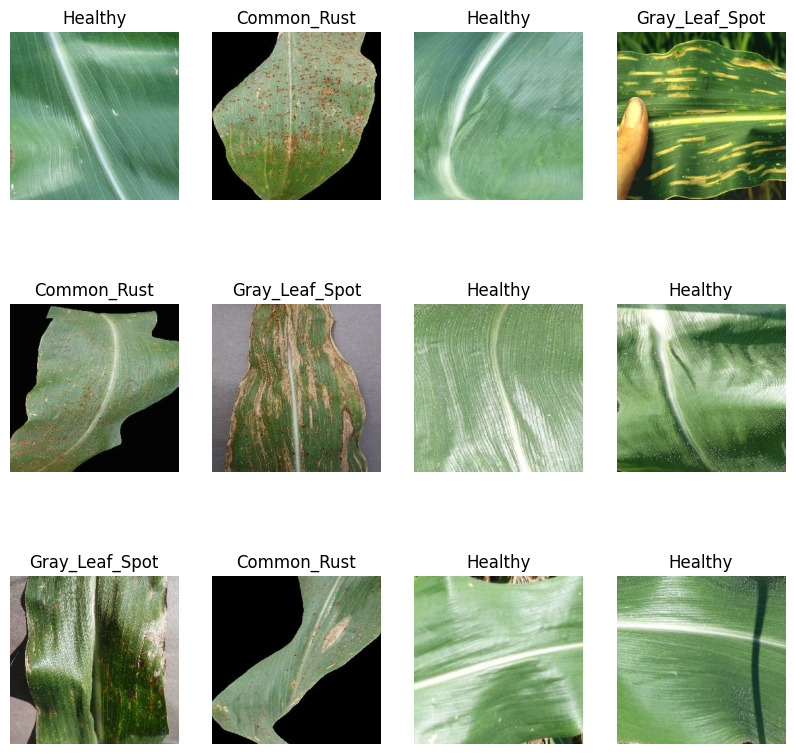

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range (12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [7]:
#training ==> 80% of data
#validation ==> 10% of data
#test ==> 10% of data

In [7]:
def split_dataset(ds,train_split,val_split,test_split,shuffle=True,shuffle_size = 10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=20)

    train_size = int(ds_size*train_split)
    val_size = int(ds_size*val_split)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds
    

In [8]:
train_ds, val_ds, test_ds = split_dataset(dataset,0.8,0.1,0.1)

In [9]:
lengths = [len(train_ds),len(val_ds),len(test_ds)]
print(f'Lengths = Train:{lengths[0]}, Validation:{lengths[1]}, Test:{lengths[2]}')

Lengths = Train:112, Validation:14, Test:14


In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) 
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) 

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256, 256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [13]:
model = tf.keras.models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters = 30, kernel_size = (3,3), activation='relu',input_shape=(30, 256, 256, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(60, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(60, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(60, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(60, activation='relu'),
    layers.Dense(4, activation='softmax')    
])

model.build(input_shape = (30, 256, 256, 3))

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (30, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (30, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (30, 254, 254, 30)        840       
                                                                 
 max_pooling2d (MaxPooling2D  (30, 127, 127, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (30, 125, 125, 60)        16260     
                                                                 
 max_pooling2d_1 (MaxPooling  (30, 62, 62, 60)         0         
 2D)                                                  

In [15]:
model.compile(
    optimizer = 'adam',
    loss = 'SparseCategoricalCrossentropy',
    metrics = ['Accuracy']
)

In [16]:
history = model.fit(
    train_ds,
    epochs = 100,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/100
112/112 [==============================] - 105s 695ms/step - loss: 0.6527 - Accuracy: 0.7237 - val_loss: 0.5207 - val_Accuracy: 0.8113
Epoch 2/100
112/112 [==============================] - 56s 495ms/step - loss: 0.4257 - Accuracy: 0.8154 - val_loss: 0.4825 - val_Accuracy: 0.8431
Epoch 3/100
112/112 [==============================] - 53s 472ms/step - loss: 0.4041 - Accuracy: 0.8292 - val_loss: 0.4719 - val_Accuracy: 0.8309
Epoch 4/100
112/112 [==============================] - 53s 472ms/step - loss: 0.4148 - Accuracy: 0.8289 - val_loss: 0.4057 - val_Accuracy: 0.8578
Epoch 5/100
112/112 [==============================] - 53s 473ms/step - loss: 0.3474 - Accuracy: 0.8429 - val_loss: 0.4752 - val_Accuracy: 0.8235
Epoch 6/100
112/112 [==============================] - 53s 473ms/step - loss: 0.3299 - Accuracy: 0.8578 - val_loss: 0.3633 - val_Accuracy: 0.8603
Epoch 7/100
112/112 [==============================] - 53s 473ms/step - loss: 0.3303 - Accuracy: 0.8545 - val_loss: 0.3564 

Epoch 57/100
112/112 [==============================] - 53s 470ms/step - loss: 0.1399 - Accuracy: 0.9459 - val_loss: 0.1486 - val_Accuracy: 0.9485
Epoch 58/100
112/112 [==============================] - 53s 470ms/step - loss: 0.1287 - Accuracy: 0.9507 - val_loss: 0.1512 - val_Accuracy: 0.9583
Epoch 59/100
112/112 [==============================] - 53s 470ms/step - loss: 0.1186 - Accuracy: 0.9525 - val_loss: 0.1052 - val_Accuracy: 0.9559
Epoch 60/100
112/112 [==============================] - 53s 470ms/step - loss: 0.1214 - Accuracy: 0.9555 - val_loss: 0.1780 - val_Accuracy: 0.9461
Epoch 61/100
112/112 [==============================] - 53s 470ms/step - loss: 0.1248 - Accuracy: 0.9528 - val_loss: 0.1328 - val_Accuracy: 0.9583
Epoch 62/100
112/112 [==============================] - 53s 470ms/step - loss: 0.1165 - Accuracy: 0.9552 - val_loss: 0.2148 - val_Accuracy: 0.9338
Epoch 63/100
112/112 [==============================] - 53s 470ms/step - loss: 0.1121 - Accuracy: 0.9555 - val_loss: 0

In [17]:
model.evaluate(test_ds)

14/14 [==============================] - 27s 160ms/step - loss: 0.1048 - Accuracy: 0.9619


[0.10481996834278107, 0.961904764175415]

In [18]:
history

In [23]:
print(history.history.keys())

dict_keys(['loss', 'Accuracy', 'val_loss', 'val_Accuracy'])


In [55]:
accuracy, va_accuracy, loss, va_loss = history.history['Accuracy'], history.history['val_Accuracy'], history.history['loss'], history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

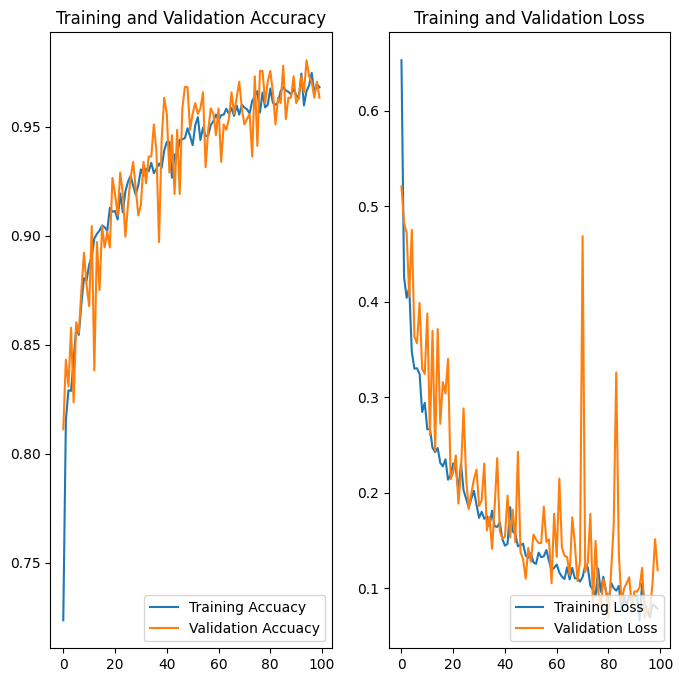

In [56]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(accuracy,label='Training Accuacy')
plt.plot(va_accuracy,label='Validation Accuacy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss,label='Training Loss')
plt.plot(va_loss,label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')


First image to predict:
Actual label: Common_Rust
Predicted label: Common_Rust


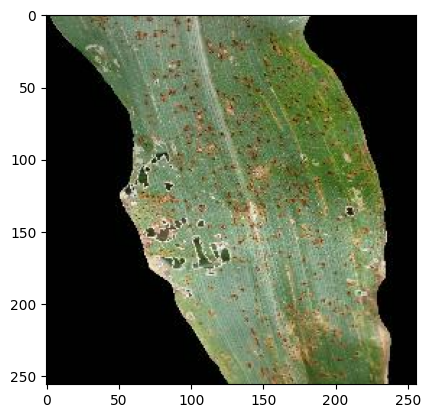

In [134]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict:")
    plt.imshow(first_image)
    print('Actual label:',class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print('Predicted label:',class_names[np.argmax(batch_prediction[0])])

In [119]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

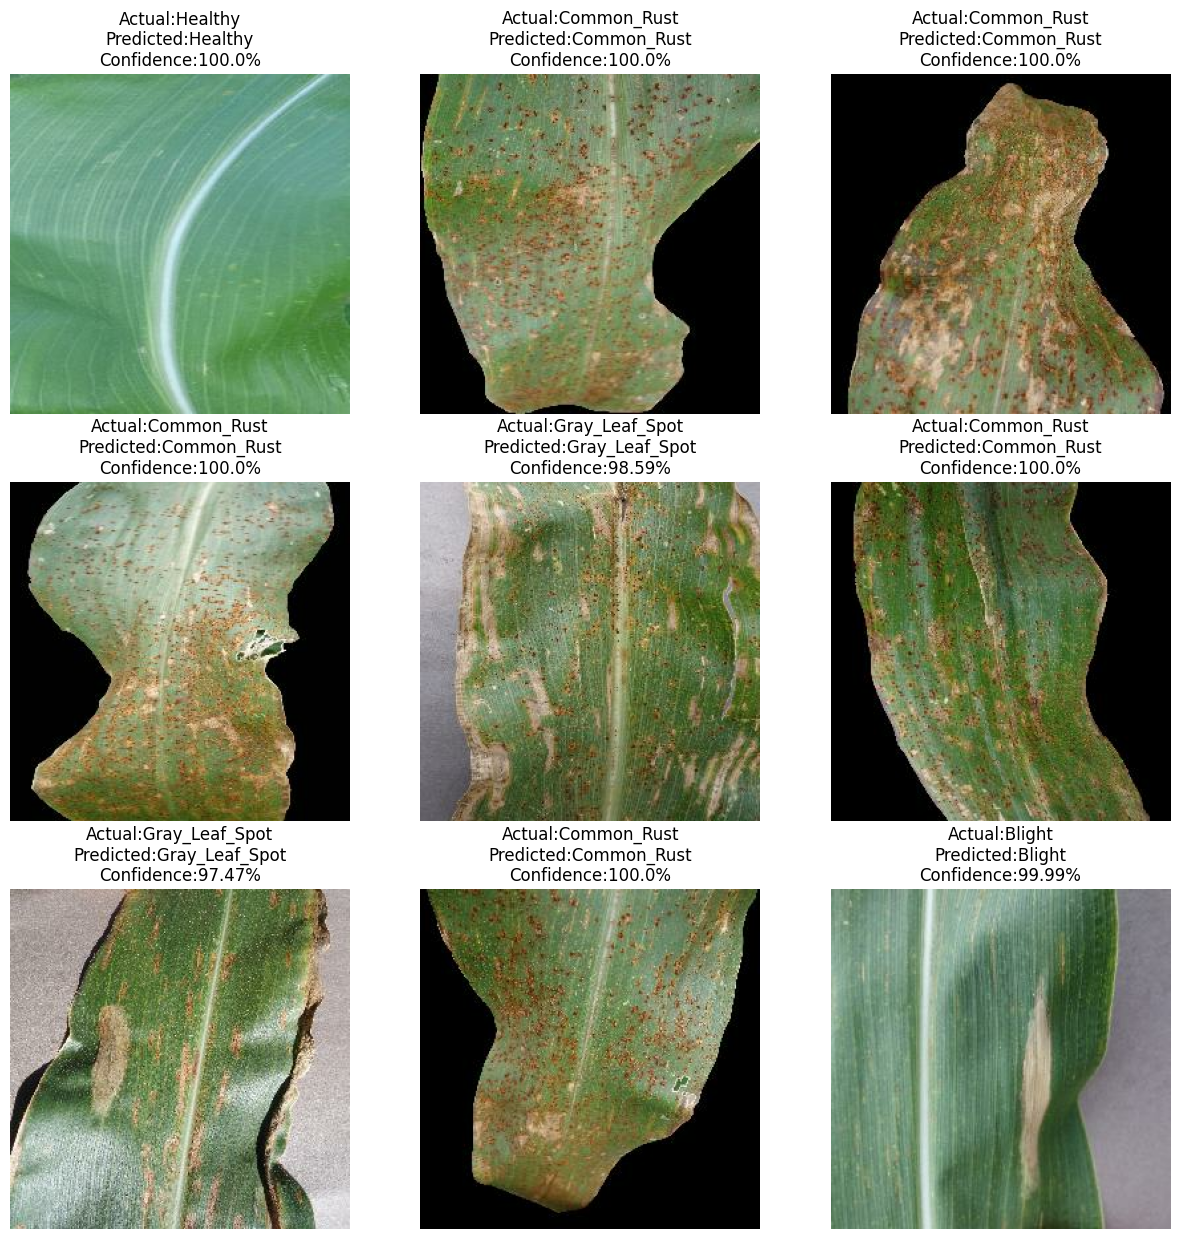

In [138]:

plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f'Actual:{actual_class}\nPredicted:{predicted_class}\nConfidence:{confidence}%')
        plt.axis('off')
        
    

In [157]:
model_version=1
model.save('../models/mymodel.h5')